The Gray-Scott model describes the reaction and diffusion of two chemicals, A and B, and can generate a wide variety of patterns depending on the rates of reaction, diffusion, feed, and kill rates of the chemicals. The discretized equations governing the system for chemical $A$ and $B$ are:

$$ A' = A + ( D_A \nabla^2 A - AB^2 + f(1-A)) \ \Delta t $$

$$ B' = B + ( D_B \nabla^2 B - AB^2 - (k+f)B) \ \Delta t $$

$D_A$ is the diffusion coefficient of chemical *A*<br>
$D_B$ is the diffusion coefficient of chemical *B*<br>
$f$ feed rate of chemical *A*<br>
$k$ kill rate of chemical *B*<br>
$\nabla^2$ is the Laplacian operator in two dimensions

The Laplacian operator measures how a function changes in all directions around a given point. It does this by calculating the second derivative of the function in both the x and y directions. Applying the Laplacian operator at a specific point is akin to examining the immediate neighborhood around that point to determine whether the point is a peak, a valley, or flat terrain. Peaks and valleys indicate local maxima and minima, where the function's value increases or decreases most steeply in all directions. In contrast, flat areas show where the function's value changes minimally. This calculation yields a single value representing the divergence or convergence of the function's gradient at that point.

The problem can be coded using constant boundary conditions or using the Born-von Karman conditions, which aims at simulating a finite media as an infinite system that "wraps around" at the edges similar to a torus. The heavy lifting in this code is done by the `convolve` function from the SciPy module, which avoids having to code an expensive regular `for` loop to scan every pixel. Another option would be to use the Numba module, which can substantially speed up Python code, but the trade off is that some functions, like `convolve`, cannot be compiled, and sticking to explicit loop-based approaches for computing the Laplacian might be more straightforward in this scenario.


In [8]:
# Import modules
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from IPython.display import clear_output


In [153]:
# Set random seed
np.random.seed(5)

# Model parameters
Da = 2e-4 # Diffusion coefficient for chemical A
Db = 1e-4 # Diffusion coefficient for chemical B
f = 0.075 # Feed rate of A
k = 0.035 # kill rate of B

# Laplacian weights
W = np.array([ [0.05, 0.2, 0.05], [0.2, -1, 0.2], [0.05, 0.2, 0.05] ])

# Grid setup
rows = 100 
cols = 100
dx = 1.0 / cols  # x step
dy = 1.0 / rows  # y step

# Time stepping
T = 2000  # Simulation time
dt = 0.01  # Time step

# Initialization
A = np.ones((rows, cols))
B = np.zeros((rows, cols))

# Set initial conditions
seeds = 1000

# Small area in the center
#A[size//2-5:size//2+5, size//2-5:size//2+5] = 0.0
#B[size//2-5:size//2+5, size//2-5:size//2+5] = 1.0

# Random seeds of A and B into each other
A[np.random.randint(0,rows,seeds), np.random.randint(0,cols,seeds)] = 0.0  
B[np.random.randint(0,rows,seeds), np.random.randint(0,cols,seeds)] = 1.0

# Pre-allocate arrays
A_all = np.full((rows, cols, T), np.nan)
B_all = np.full((rows, cols, T), np.nan)

# Create function that computes A and B in each time step
def update(A, B, W, Da, Db, f, k, dt, dx):
    A_new = np.copy(A)
    B_new = np.copy(B)
    
    # Compute Laplacian using convolution and the weights matrix
    La = convolve(A, W, mode='wrap') / (dx*dy)
    Lb = convolve(B, W, mode='wrap') / (dx*dy)
    
    # Compute reaction and update each chemical
    reaction = A*B*B
    A_new += (Da*La - reaction + f*(1-A)) * dt
    B_new += (Db*Lb + reaction - (f+k)*B) * dt
    
    return A_new, B_new

# Get time at the beginning of the simulation
tic = time.perf_counter()

# Run the simulation
for t in range(T):
    A, B = update(A, B, W, Da, Db, f, k, dt, dx)
    
    # Save current matrices
    A_all[:,:,t] = A
    B_all[:,:,t] = B
    
    
# Get time at end of simulation
toc = time.perf_counter()

# Let us know that the interpreter finished
print('Done in ',str(toc-tic))


Done in  1.564100638963282


In [154]:
def blend(M,N,alpha,rule):
    """Function to blend the matrices of the two chemicals"""
    
    if rule == 'exp':
        # Exponential merging
        I = alpha * np.exp(M) + (1 - alpha) * np.exp(N)
    
    elif rule == 'log':
        # Logarithmic merging (natural logarithm of one plus the input array to prevent log(0))
        I = alpha * np.log1p(M) + (1 - alpha) * np.log1p(N)

    elif rule == 'linear':
        I = alpha * M + (1 - alpha) * N
        
    # Normalize results
    I = (I - np.min(I)) / (np.max(I) - np.min(I))
    
    return I

In [155]:
# Blend images before looping through frames
img = blend(A_all, B_all, alpha=0.5, rule='log')


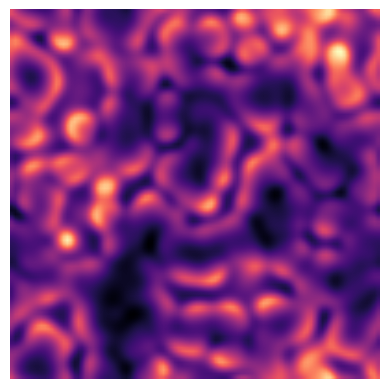

In [156]:
# Visualize changes frame by frame
frame_rate = 10 # set this to 1 for highest temporal detail)

for k in range(0, img.shape[2], frame_rate):
    clear_output(wait=True)
    plt.imshow(img[:,:,k], cmap='magma', interpolation='bilinear')
    plt.axis('off')
    plt.show()

## References

Here is an amazing online source that constituted the basis for this code: https://www.karlsims.com/rd.html